In [999]:
import math
import random
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
import operator
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score
from sklearn import svm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [978]:
iris = load_iris()

In [1013]:
# THIS FUNCTION WAS TAKEN FROM OFFICIAL SKLEARN CONFUSION MATRIX GUIDE TO PRINT
# CONFUSION MATRIXES GOOD
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [1014]:
def loadLeafData(fname):
    """
        Load required leaf informations from file. 
        **Class and Specimen Number Ignored to get good knn acc.
        
        1. Class (Species) 
        2. Specimen Number 
        3. Eccentricity 
        4. Aspect Ratio 
        5. Elongation 
        6. Solidity 
        7. Stochastic Convexity 
        8. Isoperimetric Factor 
        9. Maximal Indentation Depth 
        10. Lobedness 
        11. Average Intensity 
        12. Average Contrast 
        13. Smoothness 
        14. Third moment 
        15. Uniformity 
        16. Entropy
    """
    targetClass = []
    data = []
    with open(fname,"r") as f:
        lines = f.read().splitlines()
        for line in lines:
            tokens = line.split(",")
            targetClass.append(int(tokens[0]))
            specData = [float(token) for i, token in enumerate(tokens[2:])]
            data.append(specData)
    
    combine = list(zip(data,targetClass))
    random.shuffle(combine)
    data, targetClass = zip(*combine)
    return data, targetClass
#d,t = loadLeafData("leaf.data")
#print(d[0],t[0])

In [1015]:
def kFoldCrossValidation(data, target, k, setIndex):
    """
        K=5 Fold Cross Validation. Divide data  to 5 part and
        return setIndex th part of data
    """
    totalData = len(data) 
    setSize = int(totalData/k)

    startIndex = setSize*setIndex
    endIndex = int(startIndex + setSize)
    #print("TestData StartI:",startIndex,"\nTestData EndIndex:",endIndex)
    
    testSet = [list(d) for d in zip(data[startIndex:endIndex],target[startIndex:endIndex])]
    #print(testSet)
    trainSet = [ list(d) for i,d in enumerate(zip(data, target)) if (i<startIndex and i<=endIndex) or (i>=endIndex)]
    return trainSet, testSet


In [1016]:
def calcEuclideanDistance(point1, point2):
    """
        \brief Calculate Euclidean Distance between two point
        \return Euclidean Distance
    """
    dist = 0
    # zip items and walk them on the same time, same order
    for item1, item2 in zip(point1,point2):
        dist += pow((item1-item2),2)
    return math.sqrt(dist)

In [1017]:
def calcManhattanDistance(point1, point2):
    """
        \brief Calculate Manhattan Distance between two point
        \return Manhattan Distance
    """
    dist = 0
    for p1, p2 in zip(point1,point2):
        dist += abs(p1-p2)
    return dist

In [1018]:
def getNeighbours(train_data, test_data, k, distFunc):
    """
        Trace all neighbours of test data on train data and return first
        k distance value
    """
    dists = [ (data, distFunc(test_data, data[0])) for data in train_data]
    dists.sort(key=operator.itemgetter(1))
    return dists[:k]

In [1019]:
def getMaxOccurancedClass(neighbours):
    """
        Get max occuranced element in an neighbours array
    """
    return Counter([neighbour[0][1] for neighbour in neighbours]).most_common()[0][0]

In [1127]:
def calcConfusionMatrixAcc(matrix):
    arr = np.asarray(matrix)
    return float(sum(np.diagonal(arr)))/float(sum(sum(matrix)))

In [1121]:
def kNNIris(distanceMethod):
    """
        Run kNN on IRIS dataset according to distanceMethod and return
        target values and predictions
    """
    k=5
    allPredictions = []
    allTargetTests = []
    
    totalAccScore = 0
    for i in range(k):
        trainData, testData  = kFoldCrossValidation(iris.data, iris.target, k, i)
        irisTargetTest = [d[1] for d in testData]
        predictions = []
        for _tdata in testData:
            neighbours = getNeighbours(trainData, _tdata[0],k, distanceMethod) 
            predictions.append(getMaxOccurancedClass(neighbours))
        allPredictions += predictions
        allTargetTests += irisTargetTest
    return allTargetTests, allPredictions

In [1021]:
def kNNLeaf(distanceMethod,k):
    """
        Run kNN on LEAF dataset according to distanceMethod and return
        target values and predictions
    """
    allPredictions = []
    allTargetTests = []
    totalAccScore = 0
    
    leafData, leafTarget = loadLeafData("leaf.data")
        
    
    for i in range(k):
        trainData, testData  = kFoldCrossValidation(leafData, leafTarget, k, i)
        """
        print("TrainData[0]:",trainData[0])
        print("TestData[0]:",testData[0][0])
        """
        predictions = []
        maxOccurencedClass =0

        for _tdata in testData:
            neighbours = getNeighbours(trainData, _tdata[0],k, distanceMethod)
            maxOccurencedClass = getMaxOccurancedClass(neighbours)
            predictions.append(maxOccurencedClass)
        allPredictions += predictions
    return leafTarget, allPredictions
#tests, predictions = kNNLeaf(calcEuclideanDistance,5)
#print(tests,predictions)

KNN IRIS Data Euclidean Accuracy: 0.9133333333333333
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       0.85      0.90      0.87        50
          2       0.89      0.84      0.87        50

avg / total       0.91      0.91      0.91       150

Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.9  0.1 ]
 [0.   0.16 0.84]]


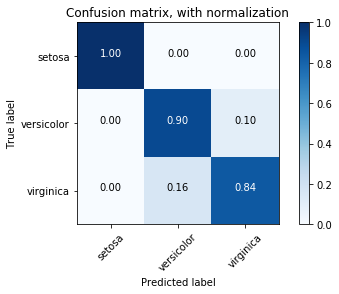

In [1022]:
def part1_iris():
    k=5
    
    targetTests,predictions = kNNIris(calcEuclideanDistance)
    report = classification_report(targetTests, predictions)
    print("KNN IRIS Data Euclidean Accuracy:",accuracy_score(targetTests,predictions))
    print(report)
    confMatrix = confusion_matrix(targetTests, predictions)
    #confMatrix = confMatrix.astype('float') / confMatrix.sum(axis=1)[:, np.newaxis]
    #print(confMatrix)
    
    plt.figure()
    plot_confusion_matrix(confMatrix, classes=iris.target_names,
                      title='Confusion matrix, with normalization', normalize=True)
    plt.show()
    

part1_iris()

In [1131]:
def part1_leaf():
    k=5
    targetTests,predictions = kNNLeaf(calcEuclideanDistance,k)
    report = classification_report(targetTests, predictions)
    confMatrix = confusion_matrix(targetTests, predictions)
    print("KNN LEAF Data Euclidean Confusion Matrix Accuracy:",calcConfusionMatrixAcc(confMatrix))
    
    #print("KNN LEAF Data Euclidean Accuracy according to prediction/trues:",accuracy_score(targetTests,predictions))
    print(report)
    
    """
    plt.figure()
    plot_confusion_matrix(confMatrix, classes=[x for x in range(1,16)],
                      title='Confusion matrix, with normalization', normalize=True)
    plt.show()
    """
    
part1_leaf()

KNN LEAF Data Euclidean Confusion Matrix Accuracy: 0.5352941176470588
             precision    recall  f1-score   support

          1       0.50      0.58      0.54        12
          2       0.10      0.10      0.10        10
          3       1.00      0.40      0.57        10
          4       0.00      0.00      0.00         8
          5       0.89      0.67      0.76        12
          6       0.67      0.25      0.36         8
          7       0.88      0.70      0.78        10
          8       1.00      1.00      1.00        11
          9       0.40      0.57      0.47        14
         10       0.60      0.46      0.52        13
         11       0.60      0.94      0.73        16
         12       0.45      0.42      0.43        12
         13       0.38      0.38      0.38        13
         14       0.40      0.50      0.44        12
         15       0.75      0.60      0.67        10
         22       1.00      0.25      0.40        12
         23       0.92      

KNN IRIS Data Manhattan Confusion Matrix Accuracy: 0.92
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       0.85      0.92      0.88        50
          2       0.91      0.84      0.87        50

avg / total       0.92      0.92      0.92       150

Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.92 0.08]
 [0.   0.16 0.84]]


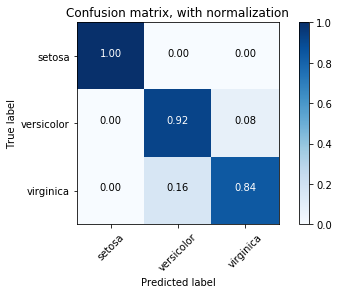

In [1133]:
def part2_iris():
    k=5
    
    targetTests,predictions = kNNIris(calcManhattanDistance)
    confMatrix = confusion_matrix(targetTests, predictions)
    
    report = classification_report(targetTests, predictions)
    print("KNN IRIS Data Manhattan Confusion Matrix Accuracy:",calcConfusionMatrixAcc(confMatrix))
    print(report)
    plt.figure()
    plot_confusion_matrix(confMatrix, classes=iris.target_names,
                      title='Confusion matrix, with normalization', normalize=True)
    plt.show()

part2_iris()

In [1137]:
def part2_leaf():
    k=5
    targetTests,predictions = kNNLeaf(calcManhattanDistance,k)
    confMatrix = confusion_matrix(targetTests, predictions)
    print("KNN LEAF Data Manhattan Confusion Matrix Accuracy:",calcConfusionMatrixAcc(confMatrix))
    
    report = classification_report(targetTests, predictions)
    print(report)
    """
    confMatrix = confusion_matrix(targetTests, predictions)
    plt.figure()
    plot_confusion_matrix(confMatrix, classes=[x for x in range(14)],
                      title='Confusion matrix, with normalization', normalize=True)
    plt.show()
    """
part2_leaf()

KNN LEAF Data Manhattan Confusion Matrix Accuracy: 0.6058823529411764
             precision    recall  f1-score   support

          1       0.67      0.83      0.74        12
          2       0.27      0.30      0.29        10
          3       0.86      0.60      0.71        10
          4       0.00      0.00      0.00         8
          5       0.92      1.00      0.96        12
          6       0.67      0.25      0.36         8
          7       0.78      0.70      0.74        10
          8       1.00      1.00      1.00        11
          9       0.71      0.71      0.71        14
         10       0.92      0.92      0.92        13
         11       0.60      0.94      0.73        16
         12       0.36      0.33      0.35        12
         13       0.33      0.46      0.39        13
         14       0.54      0.58      0.56        12
         15       0.75      0.90      0.82        10
         22       0.67      0.17      0.27        12
         23       0.91      

In [1138]:
def specializedSVM(dataSet, _kernel):
    
    if dataSet == "leaf":
        data, target = loadLeafData("leaf.data")
    elif dataSet == "iris":
        data, target = iris.data, iris.target
    else:
        raise ValueError("Only IRIS and LEAF datasets are valid.")
        
    k=5
    allPredictions = []
    allTargetTests = []
    
    totalAccScore = 0
    for i in range(k):
        trainData, testData  = kFoldCrossValidation(data, target, k, i)
        # TrainData,testData includes data and target in a list
        # TrainData = (data,target)
        #print(trainData, testData)
        
        model = svm.SVC(kernel=_kernel).fit(np.array([x[0] for x in trainData]),np.array([x[1] for x in trainData]))
                
        result = model.predict(np.array([x[0] for x in testData]))
        
        allTargetTests += [i[1] for i in testData]
        
        allPredictions +=result.tolist()
        
    return allTargetTests, allPredictions        

SVM-Linear IRIS Data Confusion Matrix Accuracy: 0.9466666666666667
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       0.92      0.92      0.92        50
          2       0.92      0.92      0.92        50

avg / total       0.95      0.95      0.95       150

Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.92 0.08]
 [0.   0.08 0.92]]


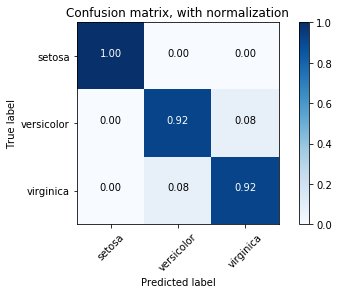

In [1139]:
def part3_iris():
 
    allTargetTests, allPredictions = specializedSVM("iris","linear")
    confMatrix = confusion_matrix(allTargetTests, allPredictions)
    
    print("SVM-Linear IRIS Data Confusion Matrix Accuracy:",calcConfusionMatrixAcc(confMatrix))
    
    report = classification_report(allTargetTests, allPredictions)
    print(report)
    
    plt.figure()
    plot_confusion_matrix(confMatrix, classes=iris.target_names,
                      title='Confusion matrix, with normalization', normalize=True)
    plt.show()
      
part3_iris()

In [1141]:
def part3_leaf():

    allTargetTests, allPredictions = specializedSVM("leaf","linear")
    confMatrix = confusion_matrix(allTargetTests, allPredictions)
    print("SVM-Linear LEAF Data Confusion Matrix Accuracy:",calcConfusionMatrixAcc(confMatrix))
    
    report = classification_report(allTargetTests, allPredictions)
    print(report)
     
    
    """plt.figure()
    plot_confusion_matrix(confMatrix, classes=iris.target_names,
                      title='Confusion matrix, with normalization', normalize=True)
    plt.show()
    """
      
part3_leaf()

SVM-Linear LEAF Data Confusion Matrix Accuracy: 0.48823529411764705
             precision    recall  f1-score   support

          1       0.37      0.58      0.45        12
          2       0.31      0.40      0.35        10
          3       1.00      0.10      0.18        10
          4       0.00      0.00      0.00         8
          5       0.71      0.83      0.77        12
          6       0.00      0.00      0.00         8
          7       0.57      0.40      0.47        10
          8       1.00      1.00      1.00        11
          9       0.50      0.71      0.59        14
         10       0.77      0.77      0.77        13
         11       0.62      0.94      0.75        16
         12       0.58      0.58      0.58        12
         13       0.30      0.54      0.39        13
         14       0.33      0.17      0.22        12
         15       0.78      0.70      0.74        10
         22       0.80      0.33      0.47        12
         23       0.80      0.

/home/hmenn/Workspace/CSE455_MachineLearning_2018/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVM-Polynomial IRIS Data Confusion Matrix Accuracy: 0.92
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       0.87      0.90      0.88        50
          2       0.90      0.86      0.88        50

avg / total       0.92      0.92      0.92       150

Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.9  0.1 ]
 [0.   0.14 0.86]]


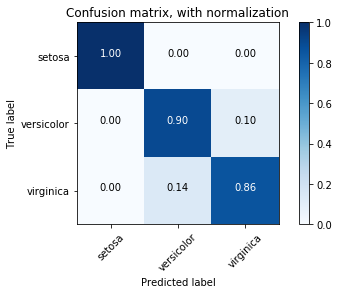

In [1142]:
def part4_iris():
 
    allTargetTests, allPredictions = specializedSVM("iris","poly")
    confMatrix = confusion_matrix(allTargetTests, allPredictions)
    print("SVM-Polynomial IRIS Data Confusion Matrix Accuracy:",calcConfusionMatrixAcc(confMatrix))
    
    report = classification_report(allTargetTests, allPredictions)
    print(report)
     
    plt.figure()
    plot_confusion_matrix(confMatrix, classes=iris.target_names,
                      title='Confusion matrix, with normalization', normalize=True)
    plt.show()
      
part4_iris()

In [1143]:
def part4_leaf():
 
    allTargetTests, allPredictions = specializedSVM("leaf","poly")
    confMatrix = confusion_matrix(allTargetTests, allPredictions)
    print("SVM-Polynomial LEAF Data Confusion Matrix Accuracy:",calcConfusionMatrixAcc(confMatrix))
    
    report = classification_report(allTargetTests, allPredictions)
    print(report)
     
    """
    plt.figure()
    plot_confusion_matrix(confMatrix, classes=iris.target_names,
                      title='Confusion matrix, with normalization', normalize=True)
    plt.show()
    """
      
part4_leaf()

SVM-Polynomial LEAF Data Confusion Matrix Accuracy: 0.20294117647058824
             precision    recall  f1-score   support

          1       0.11      0.08      0.10        12
          2       0.00      0.00      0.00        10
          3       0.00      0.00      0.00        10
          4       0.00      0.00      0.00         8
          5       0.17      0.08      0.11        12
          6       0.00      0.00      0.00         8
          7       0.00      0.00      0.00        10
          8       1.00      1.00      1.00        11
          9       0.04      0.21      0.07        14
         10       0.19      0.23      0.21        13
         11       0.64      1.00      0.78        16
         12       0.19      0.25      0.21        12
         13       0.00      0.00      0.00        13
         14       0.25      0.33      0.29        12
         15       0.50      0.10      0.17        10
         22       0.67      0.17      0.27        12
         23       0.00    

/home/hmenn/Workspace/CSE455_MachineLearning_2018/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1038]:
## DEVELOPER AREA - PLEASE DO NOT TOUCH OR RUN
def developerTests():
    
    # split data, %30->test %70->train
    #irisDataTrain, irisDataTest, irisTargetTrain, irisTargetTest = train_test_split(iris.data, iris.target, test_size=0.3)
    #print(irisTargetTest)
    #trainData = [ list(x) for x in zip(irisDataTrain, irisTargetTrain)]
    #testData = [ list(x) for x in zip(irisDataTest,irisTargetTest)]
    #print(iris.data[0],iris.data[30],iris.data[60],iris.data[90],iris.data[120])

    k=5
    trainData, testData  = kFoldCrossValidation(iris.data, iris.target, k, 0)
    #Print example 1 train data
    print("TrainData[0]:",trainData[0])
    #Print example 1 test data
    print("TestData[0]:",testData[0])
    
    # Test Euclidean Distance
    distance = calcEuclideanDistance(trainData[0][0],testData[0][0])
    print("EuclideanDistance:",distance)
    # Test Manhattan Distance
    distance = calcManhattanDistance(trainData[0][0],testData[0][0])
    print("ManhattanDistance:",distance)
    
    neighboursEuc = getNeighbours(trainData, testData[0][0],5,calcEuclideanDistance)
    print("First Neighbour(Euclidean):",neighboursEuc[0])
    neighboursMan = getNeighbours(trainData, testData[0][0],5,calcManhattanDistance)
    print("First Neighbour(Manhattan):",neighboursMan[0])
        
    ## TEST KNN-5 IrisData - Euclidead Dist
    predictions = []

    for _tdata in testData:
        # get neighbours for all test data
        neighbours = getNeighbours(trainData, _tdata[0],k, calcEuclideanDistance) 
        predictions.append(getMaxOccurancedClass(neighbours))
        
    print("\n->Report for EuclideanDistance KNN:5 on iris data")
    irisTargetTest = [d[1] for d in testData]
    accScore = accuracy_score(irisTargetTest,predictions)
    print(accScore)
    report = classification_report(irisTargetTest,predictions)
    print(report)

    ## TEST KNN-5 IrisData - Manhattan Dist
    k=5
    predictions = []

    for _tdata in testData:
        # get neighbours for all test data
        neighbours = getNeighbours(trainData, _tdata[0],k, calcManhattanDistance) 
        predictions.append(getMaxOccurancedClass(neighbours))
    
    print("\n->Report for ManhattanDistance KNN:5 on iris data")
    accScore = accuracy_score(irisTargetTest,predictions)
    print(accScore)
    report = classification_report(irisTargetTest,predictions)
    print(report)
    
#developerTests()